# Advanced Classification Predict

Kaggle Challenge 2021 - Team_15_#MLC

---

### Predict Overview: 2021/2022 Climate Change Belief Analysis

Predict an individual’s belief in climate change based on historical tweet data

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Introduction</a>

<a href=#two>2. Importing Packages</a>

<a href=#three>3. Loading Data</a>

<a href=#four>4. Data Cleaning and Preprocessing</a>

<a href=#five>5. Exploratory Data Analysis</a>

<a href=#six>6. Modeling</a>

<a href=#seven>7. Model Performance</a>

<a href=#eight>8. Conclusion</a>

<a href=#nine>9. Submission</a>

 <a id="one"></a>
## 1. Introduction

Create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

### Data Description

Data The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:

###### installations

In [1]:
!pip install wordcloud
!pip install textblob
!pip install scikit-plot
!pip install nltk
!pip install emoji --upgrade
!pip install comet_ml

#### Start Comet Experiment

In [2]:
"""
Run to create a new experiment on Comet
"""
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="0PXFIXjRITl64S9L8bH64cfYP",
    project_name="predict-advanced-classification-team-15",
    workspace="henriedwards",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/henriedwards/predict-advanced-classification-team-15/80608d20cc4243d98b5d0bc12f11f31c



 <a id="two"></a>
## 2. Importing Packages

In [3]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore')

# Install Prerequisites
import sys
import nltk

# Exploratory Data Analysis
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob



# Data Preprocessing
import string
from string import punctuation
import emoji
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import TweetTokenizer 
from nltk.tokenize import TreebankWordTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Classification Models
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB

# Performance Evaluation
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_roc, plot_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

nltk.download('wordnet')
nltk.download('stopwords')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
tokeniser = TreebankWordTokenizer()
stopwords_list = stopwords.words('english')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\happy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\happy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="three"></a>
## 3. Loading the Data
<a class="anchor" id="1.1"></a>

In [4]:
train_df = pd.read_csv('train.csv')  # For model training
test_df = pd.read_csv('test_with_no_labels.csv') # For kaggle submission

train_df_eda = pd.read_csv('train.csv') # For EDA Purposes
test_df_eda = pd.read_csv('test_with_no_labels.csv') # For EDA Purposes

train_df_hashtag = pd.read_csv('train.csv') # For Hashtag Analysis

<a id="four"></a>
## 4. Data Cleaning and Preprocessing
<a class="anchor" id="1.1"></a>
We will be using Natural Language Processing. Natural Language Processing (NLP) is a field of Artificial Intelligence (AI) that makes human language intelligible to machines. Capable of understanding, analyzing, and extracting meaning from text and speech.

In [5]:
train_df.head(3) # Basic Exploration of the Data.

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562


In [6]:
test_df.head(3) #Basic Exploration of the Data.

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985


We can clearly see noise present in the data. Text Cleaning is needed. 

In [7]:
# Rows - 15819, Columns -3
train_df.shape

(15819, 3)

In [8]:
# Look for null values and sum the total by each feature
train_df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

### Text Cleaning - Noise Removal
One of the key steps in processing language data is to remove noise so that the machine can more easily detect the patterns in the data. Text data contains a lot of noise, this takes the form of special characters such as hashtags, punctuation and numbers. All of which are difficult for computers to understand if they are present in the data.

- Function makes all input text lowercase and removes the following for better data modeling and EDA:
    - Mentions
    - Punctuations
    - Retweet "RT"
    - Hyperlink
    - StopWords
    - Tokenisation
    - Lemmatization

In [9]:
def cleaning(text):

    # Lower case Text
    text = text.lower()    
    
    # Emoji to Text
    text = emoji.demojize(text, delimiters=("", "")) 

    # Replace urls with 'url'
    url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    web = 'url'
    text = re.sub(url, web, text)
    
    # Remove retweet 'rt'
    text = re.sub("rt[\s]", "", text)
    
    # Remove Puncuation
    text = ''.join(i for i in text if i not in punctuation)
    
    # Removing non-alphabets
    text = re.sub('[^a-z]', ' ',text)

    # Tokenisation & Lemmatisation
    text = [lemmatizer.lemmatize(token) for token in text.split(' ')]
    text = [lemmatizer.lemmatize(token, 'v') for token in text]
    text = ' '.join(text)
   
    return text

#Apply data cleaning function to data
train_df['final_message'] = train_df['message'].map(cleaning)
test_df['final_message'] = test_df['message'].map(cleaning)

In [10]:
# We can see that the above funtion has been applied.
train_df.head(3)

,sentiment,message,tweetid,final_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,it not like we lack evidence of anthropogenic ...
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researcher say we have three year to ...


<a id="five"></a>
## 5. Exploratory Data Analysis
<a class="anchor" id="1.1"></a>

- WordClouds - We will use wordclouds to highlight the most frequently used words in each sentiment.
- Data Distribution - Using data distribution we can see where the majority of data lies.
- Sentiment Analysis - We will analyse each sentiment and be able to pull relevant insights per sentiment. 
- Polarity - We can use this to see what emotions are expressed in a tweet.
- Subjectivity - We will be able to see how opinionated or factual the tweets are.
- Hashtag Analysis -The most common hashtags may provide meanful insights.
- Word Frequency - 
- Bigrams - 

#### Sentiment Class Description:

- **(2) News:** the tweet links to factual news about climate change

- **(1) Pro:** the tweet supports the belief of man-made climate change

- **(0) Neutral:** the tweet neither supports nor refutes the belief of man-made climate change

- **(-1) Anti:** the tweet does not believe in man-made climate change

### WordClouds

WordClouds are used to visualize text data and display their frequency using size. The bigger the word, the more the word is used in the input text.

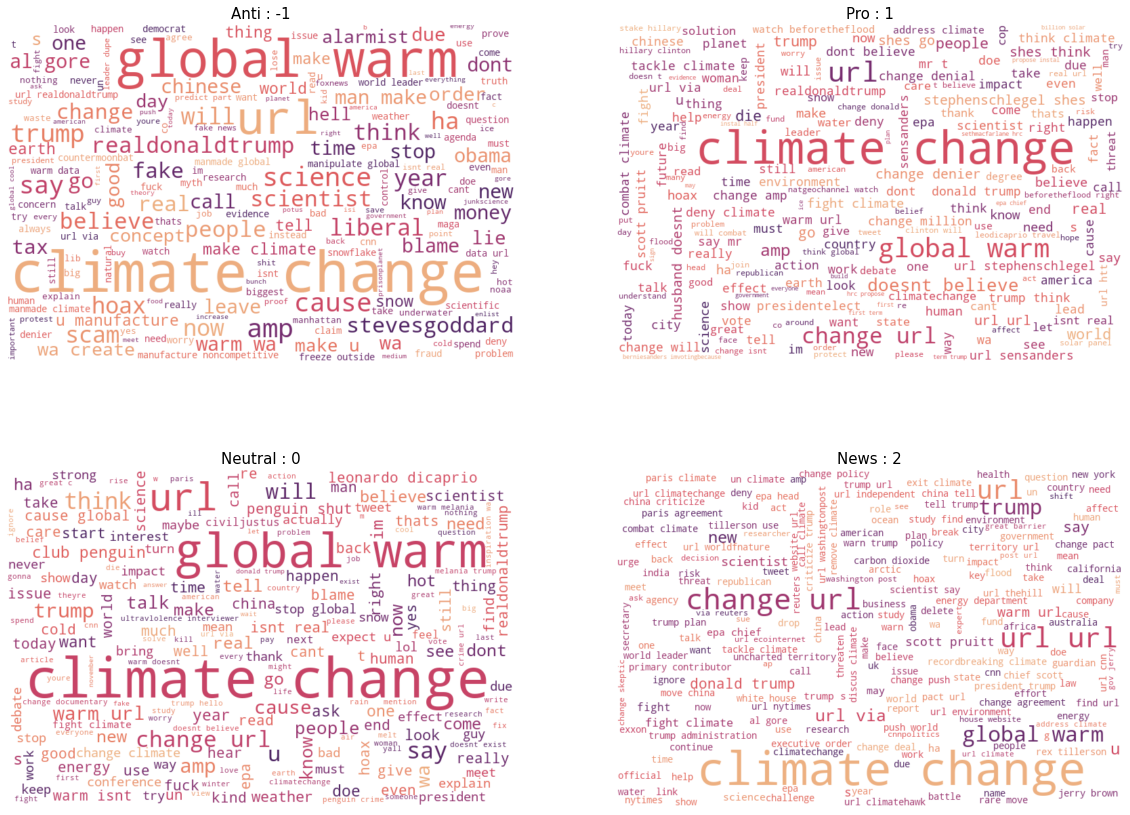

In [11]:
# Wordcloud Per Sentiment Class

anti = ' '.join([text for text in train_df['final_message'][train_df['sentiment']==-1]])
neutral = ' '.join([text for text in train_df['final_message'][train_df['sentiment']==0]])
pro = ' '.join([text for text in train_df['final_message'][train_df['sentiment']==1]])
news = ' '.join([text for text in train_df['final_message'][train_df['sentiment']==2]])

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

anti_wc = WordCloud(width=750, height=500, background_color='white', colormap='flare').generate(anti)
axis[0, 0].imshow(anti_wc, interpolation="bilinear")
axis[0, 0].set_title('Anti : -1',fontsize=15)
axis[0, 0].axis("off") 

neutral_wc = WordCloud(width=750, height=500, background_color='white', colormap='flare').generate(neutral)
axis[1, 0].imshow(neutral_wc, interpolation="bilinear")
axis[1, 0].set_title('Neutral : 0',fontsize=15)
axis[1, 0].axis("off") 

pro_wc = WordCloud(width=750, height=500, background_color='white', colormap='flare').generate(pro)
axis[0, 1].imshow(pro_wc, interpolation="bilinear")
axis[0, 1].set_title('Pro : 1',fontsize=15)
axis[0, 1].axis("off") 

news_wc = WordCloud(width=750, height=500, background_color='white', colormap='flare').generate(news)
axis[1, 1].imshow(news_wc, interpolation="bilinear")
axis[1, 1].set_title('News : 2',fontsize=15)
axis[1, 1].axis("off") 

plt.show()

Here, we can see that 'climate change' and 'global warming' are the most frequently occurring words for almost every sentiment.

Other insights per sentiment:

- **Anti (-1):** 'liberal', 'science'
- **Neutral (-0):** 'global', 
- **Pro (1):** 'believe climate'
- **News (2):** 'trump'

### Data Distribution
Data Distribution shows us the proportion of tweets per sentiment.

In [12]:
value_counts = train_df["sentiment"].value_counts()
value_counts.name = "Presence"

value_normd = train_df["sentiment"].value_counts(normalize=True)
for key, value in value_normd.items():
    value_normd[key] =  round(value*100,3)
value_normd.name = "Percentage"

display(pd.concat([value_counts, value_normd], axis=1))

,Presence,Percentage
1,8530,53.922
2,3640,23.010
0,2353,14.875
-1,1296,8.193


In [13]:
class_to_name = { # creating of dictionary for reference
    -1: "Anti",
     0: "Neutral",
     1: "Pro",
     2: "News",
}

train_df_eda["sentiment"] = train_df_eda["sentiment"].apply(lambda num: class_to_name[num])
# replace numerical sentiment with string sentiment as per above dictionary 

train_df_eda.head(2)


,sentiment,message,tweetid
0,Pro,PolySciMajor EPA chief doesn't think carbon di...,625221
1,Pro,It's not like we lack evidence of anthropogeni...,126103


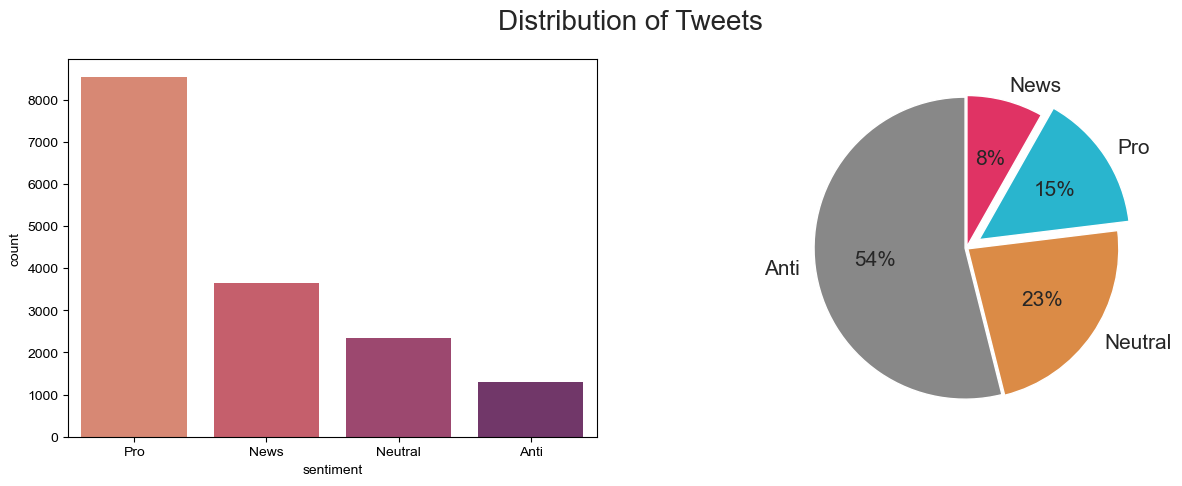

In [14]:
# Visualize the Distribution per sentiment

fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

sns.countplot(train_df_eda["sentiment"], palette ='flare',ax=axes[0])
sns.set(font_scale=1.2)
labels = list(class_to_name.values())

colors = ['#888888', '#db8b46', '#29b5ce', '#e03364'] 
explode = (0.01, 0.01, 0.1, 0.01) 

axes[1].pie(train_df_eda["sentiment"].value_counts(),
            labels=labels,
            colors=colors,
            autopct="%1.0f%%",
            startangle=90,
            explode=explode,
            textprops={'fontsize': 15})



fig.suptitle("Distribution of Tweets", fontsize=20)
plt.show()

We can note that the data is concentrated in the sentiment Pro(1), with over 50 % of the data present, which is 6 times the amount of the sentiment with the least percenrage of data Anti(-1).

### Sentiment Analysis
We apply sentiment analysis to see if we can pull any insights from how the data is present in each sentiment class.

In [15]:
frequency = {}

by_sentiment = train_df.groupby("sentiment")
for sentiment, group in by_sentiment:
    cv = CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.6, 
                             ngram_range=(1,2))
    words = cv.fit_transform(group["final_message"])
    
    n_words = words.sum(axis=0)
    word_freq = [(word, n_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    
    freq = pd.DataFrame(word_freq, columns=["word", "freq"])
    
    frequency[sentiment] = freq.head(n=10)

to_view = pd.concat(frequency, axis=1).head(n=10)
display(to_view) # visualize top 10s

-1                    0                      1        \
             word freq            word  freq             word  freq   
0         climate  797         climate  1442              url  4186   
1          change  775          change  1413           global  1595   
2  climate change  732  climate change  1386             warm  1492   
3          global  634          global  1039      global warm  1430   
4            warm  616            warm  1011            trump  1105   
5     global warm  599     global warm   995       change url  1050   
6             url  536             url   859          believe  1028   
7            make  110           trump   176            think   820   
8              wa   84             say   140  believe climate   719   
9             amp   84           think   134           doesnt   717   

             2        
          word  freq  
0        trump  1067  
1   change url   848  
2      url url   757  
3       global   507  
4         warm   447  
5  global warm   426  
6          say   332  
7          epa   264  
8    scientist   216  
9          new   191

##### choosing the hyper parameters for a vectorizer

When we use an ngram range of (1,2), we observe that all classes of the sentiment use the words "global warming" and "climate change " a lot, so we choose the range (1,2) with a max_df of 0.8 as it may give more relevant meaning for a prediction

#### Observation from our categories frequency table above :

(In a lemmatized tweet)

- the words "believe climate change", appear the most in tweets with a "Pro" sentiment, it could be that they are trying to communicate to others to believe in climate change

- interestingly the most frequent category of words in "Anti" sentiment is simarly "man climate change", however even this lemmatized phrase almost conveys a sentiment. it could be as responses to tweets by the "Pro" tweeters 

- In the "News", we observe that "trump " joins climate change in the buzz words group, as president as the time he would have had something to say and as a result his thoughts on it would become a topic. 

### Word Frequency
We can use word frequency to see the most common words in our feature column.

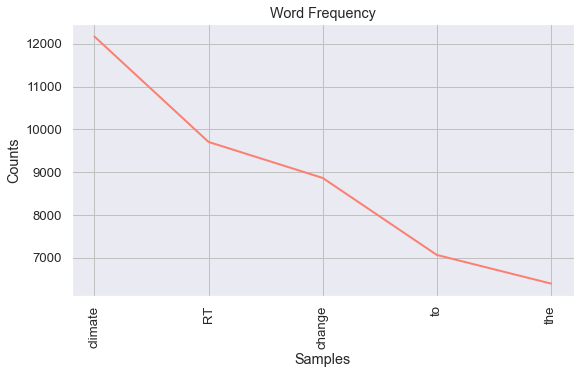

In [16]:
# Most mentioned words
# From lists of comments to a single list containing all words 

all_words=[]        
for i in range(len(train_df)):
    x = train_df["message"][i]
    a = x.split()
    all_words.append(a)

# Create sublist to have all data types in list not str
flat_list = []
for sublist in all_words:
    for word in sublist:
        flat_list.append(word)

# Word frequency
nlp_words = nltk.FreqDist(flat_list)
plt.figure(figsize=(9,5))
plot1 = nlp_words.plot(5, color='salmon', title='Word Frequency')  

    

The most commons words used are 'climate', 'change', 'global', 'warming' and 'trump'.

### Bigrams
A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A bigram is an n-gram for n=2. 

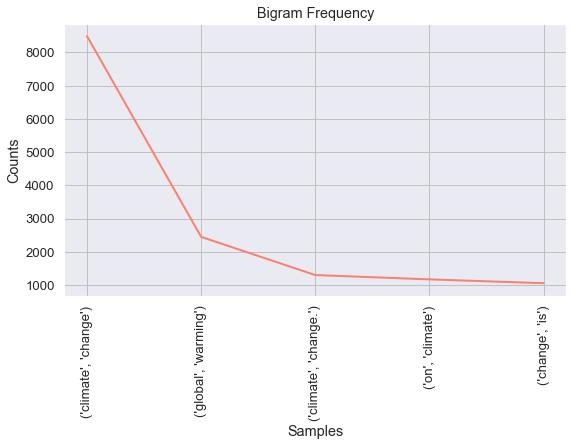

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [17]:
#most frequent pair of words that are next to each other in a comment.
bigrm = list(nltk.bigrams(flat_list))
words_2 = nltk.FreqDist(bigrm)
plt.figure(figsize=(9,5))
words_2.plot(5, color='salmon', title='Bigram Frequency')


### Subjectivity and Polarity

Polarity  refers to a higher incidence of emotional, judgmental words.

Subjectivity refers to a higher leaning of it being an opinion rather than factual information.

- Function that takes in a DataFrame. and calculates Subjectivity and Polarity.
- Creates three new features
    - Subjectivity
    - Categorial Subjectivity
    - Polarity

In [18]:
# The funtion that will analyse the sentimel and polarity
def sentiment_analysis(train_df):
#Create a function to get the polarity
    def getSubjectivity(train_df):
              
        return TextBlob(train_df).sentiment.subjectivity
  
 #Create a function to get the polarity
    def getPolarity(train_df):
        
        
        return TextBlob(train_df).sentiment.polarity
  
 #Create two new columns ‘Subjectivity’ & ‘Polarity’
    train_df['Subjectivity'] =  train_df['message'].apply(getSubjectivity)
    train_df ['Polarity'] = train_df['message'].apply(getPolarity)
# The is getting score which will decide ether Negative, Positve or Neutral sentimel
    def getAnalysis(score):
        
        
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'
    train_df ['Subjectivity_Category'] = train_df  ['Polarity'].apply(getAnalysis )
    return train_df.head()

In [19]:
sentiment_analysis(train_df)

,sentiment,message,tweetid,final_message,Subjectivity,Polarity,Subjectivity_Category
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,0.166667,0.083333,Positive
1,1,It's not like we lack evidence of anthropogeni...,126103,it not like we lack evidence of anthropogenic ...,0.000000,0.000000,Neutral
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researcher say we have three year to ...,0.600000,-0.300000,Negative
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wire wa a pivotal year in t...,0.800000,0.500000,Positive
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas it and a racist sexist cl...,0.000000,0.000000,Neutral


We can visualize the Polarity and Subjectivity to get a better understanding.

Text(0, 0.5, 'Subjectivity')

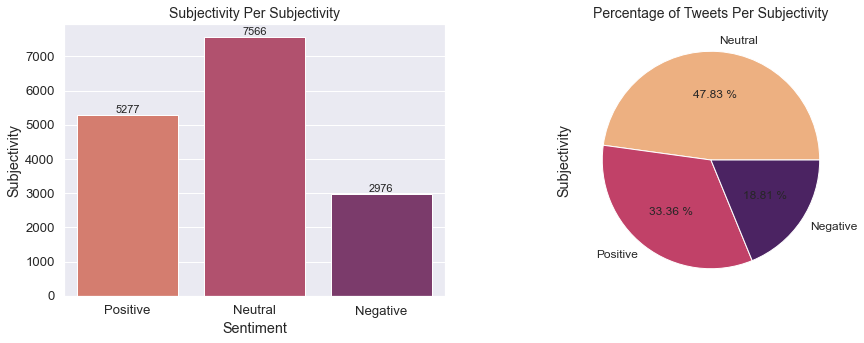

In [20]:
# Visualize the Distribution per sentiment
fig, axis = plt.subplots(ncols=2, figsize=(15, 5))

ax = sns.countplot(x='Subjectivity_Category', data=train_df, palette='flare', ax=axis[0])
axis[0].set_title('Subjectivity Per Subjectivity',fontsize=14)
axis[0].set_xlabel('Sentiment')
axis[0].set_ylabel('Subjectivity')
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2., i.get_height(), '%d' % int(i.get_height()), fontsize=11, ha='center', va='bottom')
    
train_df['Subjectivity_Category'].value_counts().plot.pie(autopct='%1.2f %%', colormap='flare', textprops={'fontsize': 12})
axis[1].set_title('Percentage of Tweets Per Subjectivity',fontsize=14)
axis[1].set_ylabel('Subjectivity')

<AxesSubplot:xlabel='Polarity', ylabel='Count'>

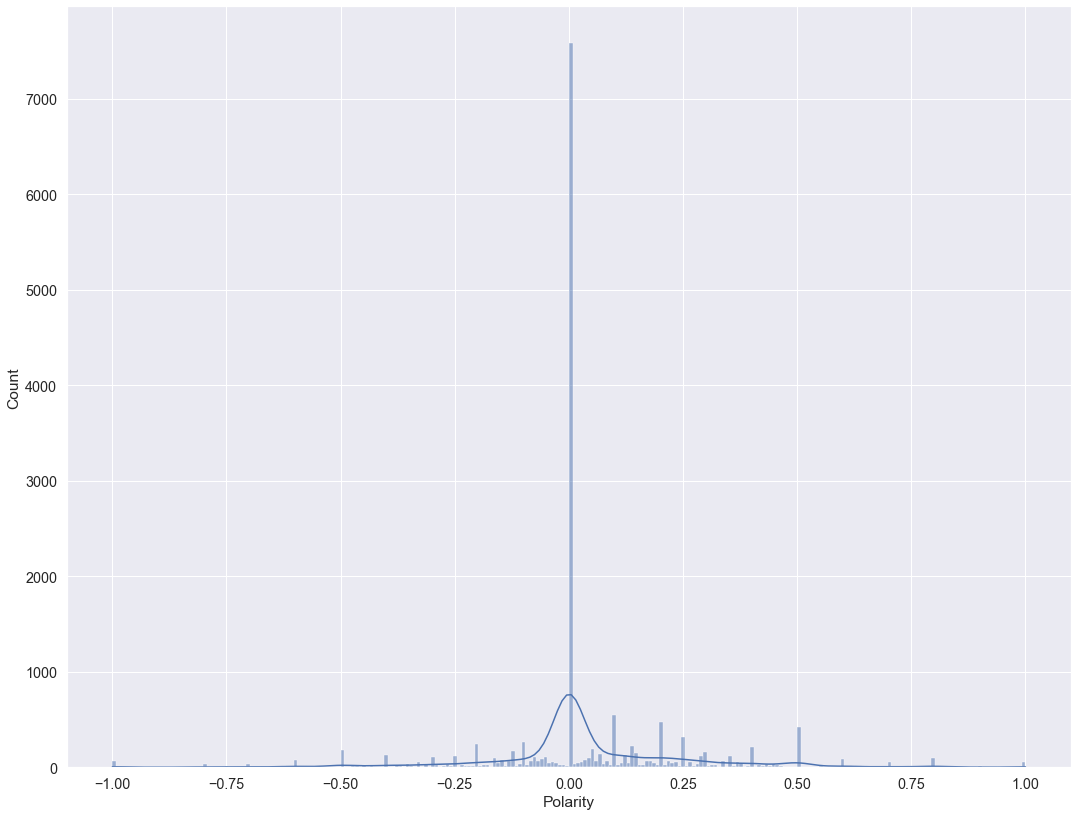

In [29]:
# here we are checking for the distribution of Polarity
sns.histplot(data=train_df, x="Polarity", kde=True)

<AxesSubplot:xlabel='Polarity', ylabel='Subjectivity'>

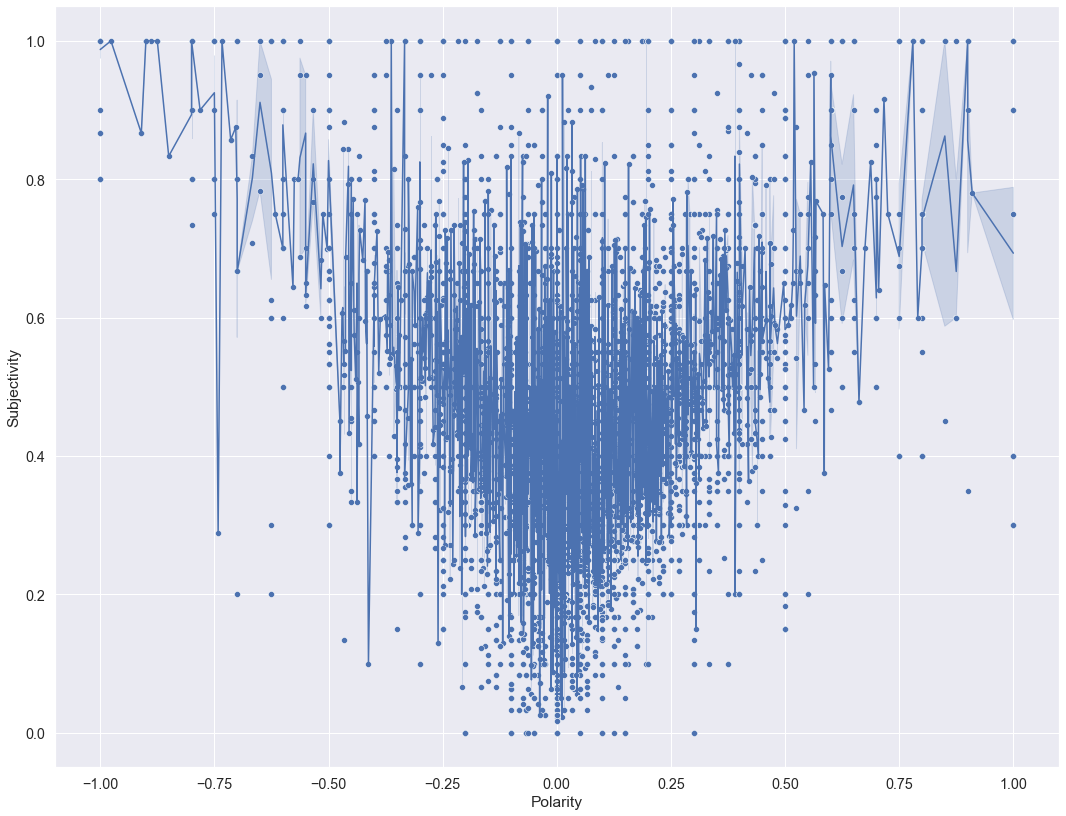

In [32]:
# checking how the polarity and Subjectivity behave to each other
sns.lineplot(data=train_df, x="Polarity", y="Subjectivity")
sns.scatterplot(data=train_df, x="Polarity", y="Subjectivity")

### Hashtag Analysis
We can extract the Hashtag data from the raw data to find out what is the popular hashtags used by each sentiment.

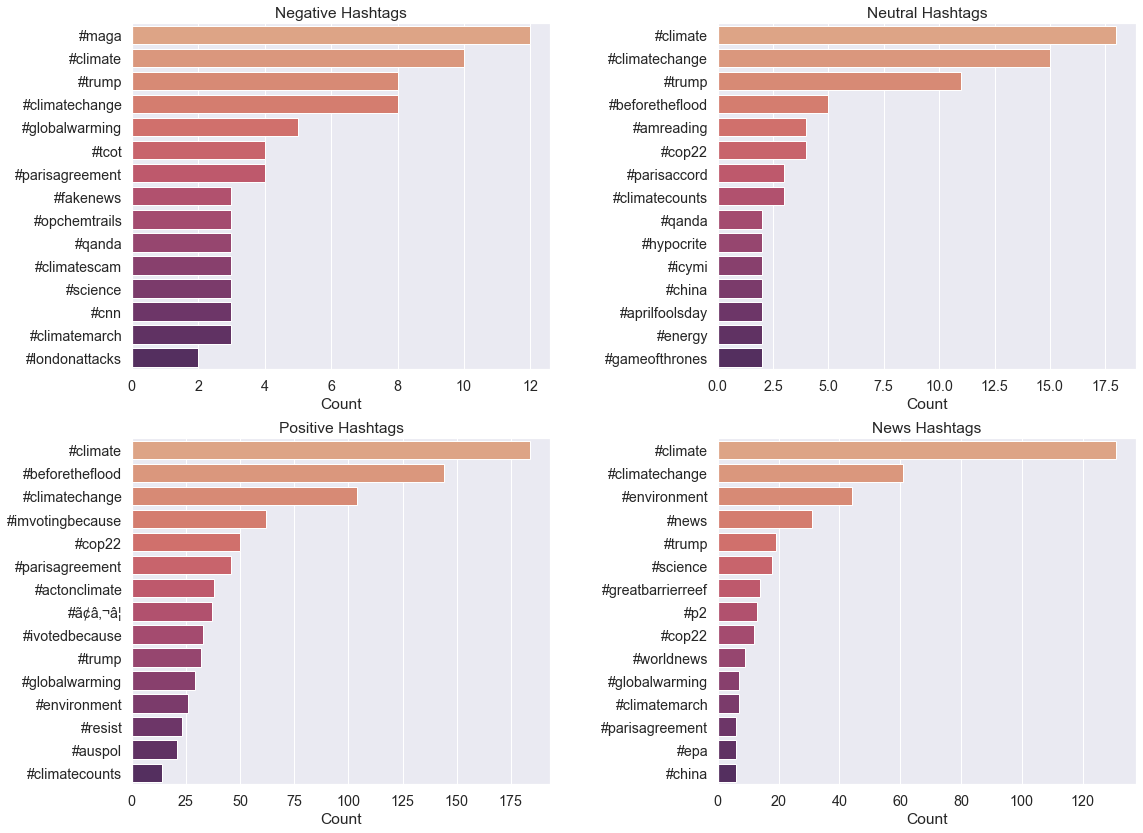

In [21]:
def hashtag(text, symbol='#'): #function that takes in text, and extracts the necessary data based on the symbol
    
    """ Function takes in a dataframe column and specified symbol, returns extracted symbol and text"""
    
    return [tag.lower() for tag in text.split() if tag.startswith(symbol)]

train_df_hashtag['hashtags'] = train_df_hashtag['message'].apply(hashtag) # apply the function


"""
The following code extracts the hashtags based on each sentiment, and gets the sum of each hashtag

"""

negative_hashtag = train_df_hashtag['hashtags'][train_df_hashtag['sentiment'] == -1]
negative_hashtag = sum(negative_hashtag, [])
neg1 = nltk.FreqDist(negative_hashtag)
neg = pd.DataFrame({'Hashtag': list(neg1.keys()), 'Count': list(neg1.values())})
neg = neg.nlargest(columns = 'Count', n = 15)

neutral_hashtag = train_df_hashtag['hashtags'][train_df_hashtag['sentiment'] == 0]
neutral_hashtag = sum(neutral_hashtag, [])
neu1 = nltk.FreqDist(neutral_hashtag)
neu = pd.DataFrame({'Hashtag': list(neu1.keys()), 'Count': list(neu1.values())})
neu = neu.nlargest(columns = 'Count', n = 15)

positive_hashtag = train_df_hashtag['hashtags'][train_df_hashtag['sentiment'] == 1]
positive_hashtag = sum(positive_hashtag, [])
pos1 = nltk.FreqDist(positive_hashtag)
pos = pd.DataFrame({'Hashtag': list(pos1.keys()), 'Count': list(pos1.values())})
pos = pos.nlargest(columns = 'Count', n = 15)

news_hashtag = train_df_hashtag['hashtags'][train_df_hashtag['sentiment'] == 2]
news_hashtag = sum(news_hashtag, [])
new1 = nltk.FreqDist(news_hashtag)
new = pd.DataFrame({'Hashtag': list(new1.keys()), 'Count': list(new1.values())})
new = new.nlargest(columns = 'Count', n = 15)

# Creation of seaborn barplots, Hashtag Counts per Sentiment

sns.set(rc={"figure.figsize":(18, 14)}, font_scale=1.3) 

fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace = 0.4)
sns.barplot(data=neg, y ='Hashtag', x ='Count', palette='flare', orient='h', ax=axes[0,0]).set(title='Negative Hashtags', ylabel=None)
sns.barplot(data=neu, y ='Hashtag', x ='Count', palette='flare', orient='h', ax=axes[0,1]).set(title='Neutral Hashtags', ylabel=None)
sns.barplot(data=pos, y ='Hashtag', x ='Count', palette='flare', orient='h', ax=axes[1,0]).set(title='Positive Hashtags', ylabel=None)
sns.barplot(data=new, y ='Hashtag', x ='Count', palette='flare', orient='h', ax=axes[1,1]).set(title='News Hashtags', ylabel=None)

plt.show()

We see note that #climate and #climatechange are the hashtags used the most in the News & Positive sentiments. Negative hashtags seems to have #maga, #climate and #trump as the mostly used hashtags. Neutral sees #climate and #climatechange to be most used, with #trump not far behind.

<a id="six"></a>
## 6. Modeling
<a class="anchor" id="1.1"></a>
In this section we will get the models ready for training, and perform training using 6 different classification algorithms.

### Split Training and Validation Sets

- Training and Validation Sets
- A vectorizer helps us convert text data to computer understandable numeric data.

In [22]:
# training and validation sets split

y = train_df['sentiment']
X = train_df['final_message'] # Stemming performs better overall compared to lemmanization

#vect = CountVectorizer(min_df=0, max_df=0.8, ngram_range=(1,2)) # best for Logreg
vect = TfidfVectorizer(stop_words='english', min_df=0, max_df=0.8, ngram_range=(1,2)) # best for Linear SVC
X = vect.fit_transform(X) # applies this transformation model (vectorizer)

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.1, random_state=42, shuffle=True, stratify = y) 
# stratify splits y values (0,1,2's) equally in the sets

## Training of Models
### Logistic Regression Model
It is a classification algorithm in machine learning that uses one or more independent variables to determine an outcome. The outcome is measured with a dichotomous variable meaning it will have only two possible outcomes.

In [23]:
# train Logistic Regression Model
modeltime = time.time()

lrm = LogisticRegression()
lrm.fit(X_train, y_train)
y_pred = lrm.predict(X_val)

lrm_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
lrm_time = round(((time.time() - modeltime)),2)
print(lrm_time)

Accuracy 0.7142857142857143
Model Runtime: 11.75 seconds
11.75


### Decision Tree Classifier
The decision tree algorithm builds the classification model in the form of a tree structure. It utilizes the if-then rules which are equally exhaustive and mutually exclusive in classification. The process goes on with breaking down the data into smaller structures and eventually associating it with an incremental decision tree. The final structure looks like a tree with nodes and leaves.

In [24]:
# train Decision Tree Classifier
modeltime = time.time()

dtc = DecisionTreeClassifier() 
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_val)

dtc_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
dtc_time = round(((time.time() - modeltime)),2)
print(dtc_time)

Accuracy 0.6485461441213654
Model Runtime: 18.00 seconds
18.0


### Random Forest Classifier
Random decision trees or random forest are an ensemble learning method for classification, regression, etc. It operates by constructing a multitude of decision trees at training time and outputs the class that is the mode of the classes or classification or mean prediction(regression) of the individual trees.

In [42]:
# train Random Forest Classifier
modeltime = time.time()

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)

rfc_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
rfc_time = round(((time.time() - modeltime)),2)
print(rfc_time)

Accuracy 0.6965865992414665
Model Runtime: 195.76 seconds
195.76


### Support Vector Machine
The support vector machine is a classifier that represents the training data as points in space separated into categories by a gap as wide as possible. New points are then added to space by predicting which category they fall into and which space they will belong to margin, hyperplane and support vectors.

In [ ]:
# train Support Vector Machine
modeltime = time.time()

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)

svc_f1 = round(f1_score(y_val, y_pred, average='micro'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
svc_time = round(((time.time() - modeltime)),2)
print(svc_time)

### Linear Support Vector Machine
The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data. From there, after getting the hyperplane, you can then feed some features to your classifier to see what the "predicted" class is. Linear SVM has kernel set to 'linear'.

In [ ]:
# train Linear Support Vector Machine
modeltime = time.time()

lsvc = LinearSVC(C=1, max_iter=100, random_state=42)
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_val)

lsvc_f1 = round(f1_score(y_val, y_pred, average='micro'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
lsvc_time = round(((time.time() - modeltime)),2)
print(lsvc_time)

### K Neighbours Classifier
It is a lazy learning algorithm that stores all instances corresponding to training data in n-dimensional space. It is a lazy learning algorithm as it does not focus on constructing a general internal model, instead, it works on storing instances of training data.

In [ ]:
# train K Neighbours Classifier
modeltime = time.time()

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
y_pred = knc.predict(X_val)

knc_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
knc_time = round(((time.time() - modeltime)),2)
print(knc_time)

### Performance Evaluation Techniques
#### Confusion Matrix
A confusion matrix is a performance measurement technique for Machine learning classification.

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. For more info about the confusion

#### Classification Report
A Classification report is used to measure the quality of predictions from a classification algorithm

- Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

- Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. 

- Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class, yes. 

- F1 score - F1 Score is the weighted average of Precision and Recall.


### Performance Evaluation

In [ ]:
# Compare Weighted F1-Scores Between Models
fig,axis = plt.subplots(figsize=(11, 3))
rmse_y = ['Logistic Regression','Random Forest Classifier','Support Vector Machine','Linear Support Vector Machine','K Neighbours Classifier','Decision Tree Classifier']
rmse_x = [lrm_f1,rfc_f1,svc_f1, lsvc_f1,knc_f1,dtc_f1]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Weighted F1-Score Per Classification Model',fontsize=15)
plt.xlabel('Weighted F1-Score', size=14)
plt.yticks(size=14)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(i.get_x() + i.get_height()/1.05, i.get_y() + i.get_height()-0.2, round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
    
plt.show()

Evaluate and compare the time each model takes to train and hyperparameter tune

In [ ]:
# Compare Training Times Between Models

fig,axis = plt.subplots(figsize=(11, 2))
rmse_y = ['Logistic Regression','Random Forest Classifier','Support Vector Machine','Linear Support Vector Machine','K Neighbours Classifier','Decision Tree Classifier']
rmse_x = [lrm_time,rfc_time, svc_time, lsvc_time, knc_time, dtc_time]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Training Time of Classification Models',fontsize=15)
plt.xlabel('Training Time', size=14)
plt.yticks(size=14)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(i.get_x() + i.get_height()/1.05, i.get_y() + i.get_height()-0.2, round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
     
plt.show()



<a id="seven"></a>
## 7. Model Performance
<a class="anchor" id="1.1"></a>

### Hyperparameter tuning of best performing Models

We are using GridSearchCV for hyperparameter tuning. K-fold cross-validation is also applied. (as cv = 3)

### Hyperparameter Tuning of Logistic Regression Model

In [ ]:
# LogisticRegression().get_params() To see all avaible parameters to tune

modeltime = time.time()

param_grid ={'C' : [0.1, 1, 10],
'max_iter' : [200, 350]}

lrm = LogisticRegression()
best_log = GridSearchCV(lrm, param_grid = param_grid, cv = 3)
best_log.fit(X_train ,y_train)
best_log.best_params_

y_pred = best_log.predict(X_val)
print("Best parameters:")
print(best_log.best_params_)

lrm_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
lrm_time = round(((time.time() - modeltime)),2)
print(lrm_time)

# Create Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()

# A confusion matrix is used to evaluate the performance of the model

plot_confusion_matrix(y_val, y_pred, normalize=True,figsize=(8,8),cmap='flare')
plt.show()

In [ ]:
# A Classification report is used to measure the quality of predictions from a classification algorithm
results

### Hyperparameter Tuning of Support Vector Classifier

In [ ]:
# SVC().get_params() To see all avaible parameters to tune

modeltime = time.time()

param_grid ={'kernel' : ['rbf'],
'C' : [1, 3, 6]}

svc = SVC()
best_svc = GridSearchCV(svc, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_svc.fit(X_train ,y_train)
best_svc.best_params_
y_pred = best_svc.predict(X_val)
print("Best parameters:")
print(best_svc.best_params_)

svc_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
svc_time = round(((time.time() - modeltime)),2)
print(svc_time)

# Create Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()

# A confusion matrix is used to evaluate the performance of the model

plot_confusion_matrix(y_val, y_pred, normalize=True,figsize=(8,8),cmap='flare')
plt.show()

In [ ]:
# A Classification report is used to measure the quality of predictions from a classification algorithm
results

### Hyperparameter Tuning of Linear Support Vector Machine

In [ ]:
LinearSVC().get_params()

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters:
{'C': 1, 'dual': True, 'loss': 'squared_hinge', 'max_iter': 55, 'random_state': None}
Accuracy 0.7383059418457648
Model Runtime: 144.81 seconds
144.81


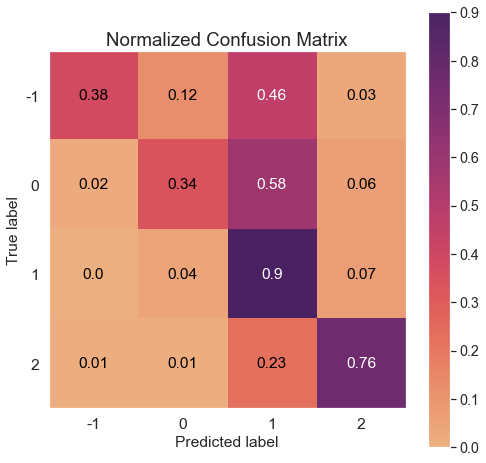

In [ ]:
# LinearSVC().get_params() To see all avaible parameters to tune

modeltime = time.time()

param_grid = {'C': [1, 10],
'max_iter': [55,65,75],
'random_state' : [None, 42],
'loss':['hinge', 'squared_hinge'],
'dual': [True, False]} 

lsvc = LinearSVC()
best_lsvc = GridSearchCV(lsvc, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_lsvc.fit(X_train ,y_train)
best_lsvc.best_params_
y_pred = best_lsvc.predict(X_val)
print("Best parameters:")
print(best_lsvc.best_params_)

lsvc_f1 = round(f1_score(y_val, y_pred, average='weighted'),2)
print('Accuracy %s' % accuracy_score(y_pred, y_val))
print("Model Runtime: %0.2f seconds"%((time.time() - modeltime)))
lsvc_time = round(((time.time() - modeltime)),2)
print(lsvc_time)

# Create Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
results = pd.DataFrame(report).transpose()

# A confusion matrix is used to evaluate the performance of the model

plot_confusion_matrix(y_val, y_pred, normalize=True,figsize=(8,8),cmap='flare')
plt.show()

In [ ]:
# A Classification report is used to measure the quality of predictions from a classification algorithm
results

,precision,recall,f1-score,support
-1,0.833333,0.384615,0.526316,130.000000
0,0.607692,0.336170,0.432877,235.000000
1,0.733205,0.895662,0.806332,853.000000
2,0.785714,0.755495,0.770308,364.000000
accuracy,0.738306,0.738306,0.738306,0.738306
macro avg,0.739986,0.592986,0.633958,1582.000000
weighted avg,0.734871,0.738306,0.719558,1582.000000


### Performance 
Evaluate increased performance after Hyperparameter Tuning

In [ ]:
# Compare Weighted F1-Scores Between Models

fig,axis = plt.subplots(figsize=(11, 2))
rmse_y = ['Logistic Regression','Support Vector Machine','Linear Support Vector Machine']
rmse_x = [lrm_f1,svc_f1,lsvc_f1]
ax = sns.barplot(y=rmse_y, x=rmse_x,palette='flare')
plt.title('Weighted F1-Score Per Classification Model',fontsize=15)
plt.xlabel('Weighted F1-Score', size=14)
plt.yticks(size=14)
plt.xticks(size=12)
for i in ax.patches:
    ax.text(i.get_x() + i.get_height()/1.05, i.get_y() + i.get_height()-0.2, round(i.get_width(),2), fontsize=12, ha="left", va='bottom')
    
plt.show()



After hyperparameter tuning, Logistic Regression and Linear SVM are the still highest performing models based on F1 Score.

### Logging Results to Comet

In [ ]:
# Get necessary metrix for comet experiment
f1_svc = f1_score(y_val, y_pred, average='weighted')
precision_svc = precision_score(y_val, y_pred, average='weighted')
recall_svc = recall_score(y_val, y_pred, average='weighted')
accuracy_svc = round(accuracy_score(y_val, y_pred),2)

In [ ]:
# Create dictionaries for the data we want to log
params_comet = {'C': 1, 'max_iter': 55, 'random_state': None}
metrics_svc = {"Accuracy": accuracy_svc, "f1" : f1_svc, "recall" : recall_svc, "precision": precision_svc}

In [ ]:
# log our parameters and results
experiment.log_parameters(params_comet)
experiment.log_metrics(metrics_svc)

In [ ]:
experiment.end()

In [ ]:
experiment.display()

### Make Predictions on Test Data

In [ ]:
X_test = test_df['final_message']
X_test = vect.transform(X_test)

In [ ]:
# predict on test data using Linear SVC - Best performing Model with best hyperparameters (C=1, max_iter=100)
lsvc = LinearSVC(C=1, max_iter=55, dual = False, loss='squared_hinge', random_state = None)
lsvc.fit(X, y)
y_pred = lsvc.predict(X_test)

In [ ]:
test_df['sentiment'] = y_pred

<a id="eight"></a>
## 8. Conclusion
<a class="anchor" id="1.1"></a>
We have chosen the **Linear SVM algorithm.**

- Linear SVM algorithm performs the best on predicting whether a person believe in climate change or not based on twitter  messages, on unseen data.

- Linear SVM also performed the best regarding model training time.         
    - LSVC train time + Hyperparameter Tuning = +- 7 Seconds
    - The closest performing model, is Logistic Regression. Logreg train time + Hyperparameter Tuning = +- 190 Seconds
    
- Linear SVM scored 0.74699 when submitted on Kaggle.

<a id="ten"></a>
## 9. Submission
<a class="anchor" id="1.1"></a>
Creating a submission file to be submitted to kaggle with specified columns

In [ ]:
test_df[['tweetid','sentiment']].to_csv('submission.csv', index=False)